In [26]:
import lightly
import lightly.utils.io as io
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import pytorch_lightning as pl
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import json
import sklearn
import torch.optim as optim


In [27]:
root_results_path = '/projects/self_supervised/results/jaw_side_simclr'

In [28]:
#load config
conf_path = os.path.join(root_results_path,'conf.json')
with open(conf_path,'r') as f:
    conf = json.load(f)

#load embeddings
embeddings_path = os.path.join(root_results_path,'embeddings.csv')
train_embeddings, train_labels, train_filenames = io.load_embeddings(embeddings_path)

#load model
model_path = os.path.join(root_results_path,'checkpoint.pth')

num_ftrs = conf['num_ftrs']

resnet = lightly.models.ResNetGenerator('resnet-18')
last_conv_channels = list(resnet.children())[-1].in_features
backbone = nn.Sequential(
    *list(resnet.children())[:-1],
    nn.Conv2d(last_conv_channels, num_ftrs, 1),
    nn.AdaptiveAvgPool2d(1)
)

if conf['model_name'] == 'simclr':
    model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)
elif conf['model_name'] == 'moco':
    model = lightly.models.MoCo(backbone, num_ftrs=num_ftrs, m=0.99, batch_shuffle=True)

encoder = lightly.embedding.SelfSupervisedEmbedding(
    model,
    None,
    None,
    None
)

encoder.model.load_state_dict(torch.load(model_path))
encoder.model.eval()

SimCLR(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): Bat

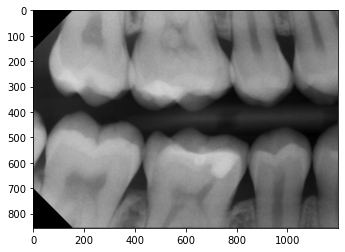

In [29]:
#load an image
data_path = '/projects/self_supervised/data/jaw_side'
category = 'jaw-right' # jaw-left, jaw-right, other

category_path = os.path.join(data_path,category)
filename_list = os.listdir(category_path)
idx = np.random.randint(len(filename_list))
filename = filename_list[idx]
img = Image.open(os.path.join(category_path,filename)).convert('RGB')
plt.imshow(img)  

jaw-right/b2RosB0ZUWl-.jpg


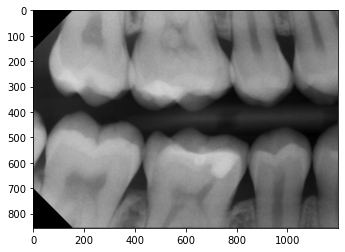

jaw-right/yIN55ofAbwj1.jpg


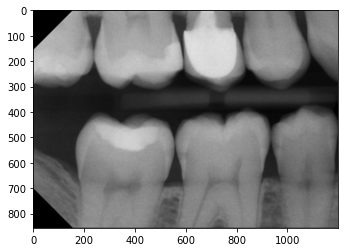

jaw-right/kFx9LQM8f0DC.jpg


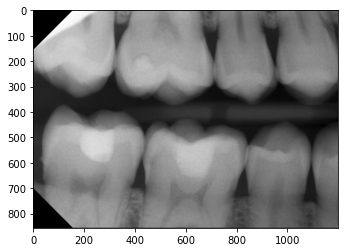

jaw-right/HQijEQSQfI27.jpg


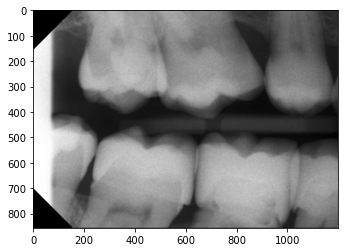

jaw-right/4oOa232R1efY.jpg


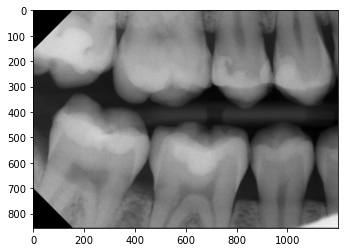

jaw-right/IJGCiKuO4IEG.jpg


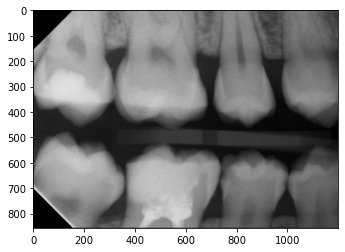

jaw-right/C9x1BCYH-yFM.jpg


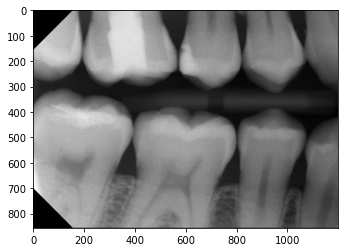

jaw-right/K5xKTthBdmxl.jpg


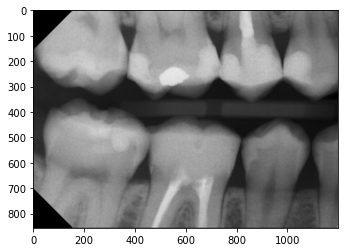

jaw-right/t9mfPTAZJ7v7.jpg


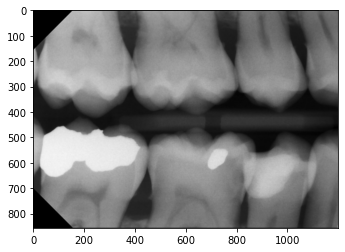

In [30]:
n_neighbors = 10


input_size = conf['input_size']

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

img_tensor = test_transforms(img)
with torch.no_grad():
    #apply the encoder
    img_embed = model.backbone(torch.unsqueeze(img_tensor,0))
    
img_embed = torch.squeeze(torch.squeeze(img_embed,2),2).numpy()
embeddings = np.concatenate((train_embeddings,img_embed))
embeddings = normalize(embeddings)
filenames = train_filenames.copy()
filenames.append(filename)

idx = filenames.index(filename)

#fit nearest neighbours
nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)

for neighbor_idx in indices[idx][1:]:
    print(filenames[neighbor_idx])
    img = Image.open(os.path.join(data_path,filenames[neighbor_idx])).convert('RGB')
    plt.imshow(img)
    plt.show()

# Linear probe

In [31]:
max_epochs = 10
input_size = 64
batch_size = 16
num_workers = 4
output_dim = 2

In [32]:
train_classifier_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

dataset_classifier = lightly.data.LightlyDataset(
    input_dir=data_path,
    transform=train_classifier_transforms
)


X_train, X_test = train_test_split(np.arange(len(dataset_classifier)), test_size=0.33)

dataset_train_classifier = torch.utils.data.Subset(dataset_classifier, X_train)
dataloader_train_classifier = torch.utils.data.DataLoader(
    dataset_classifier,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

dataset_test_classifier = torch.utils.data.Subset(dataset_classifier, X_test)
dataloader_test_classifier = torch.utils.data.DataLoader(
    dataset_test_classifier,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=num_workers
)

In [34]:
#pytorch module
class Classifier_torch(nn.Module):
    def __init__(self, model,num_ftrs,output_dim):
        super().__init__()
        
        self.net = model
        
        # freeze the layers
        for p in self.net.parameters():  # reset requires_grad
            p.requires_grad = False

        self.fc = nn.Linear(num_ftrs, output_dim)

    def forward(self, x):
        with torch.no_grad():
            y_hat = self.net.backbone(x).squeeze()
            y_hat = nn.functional.normalize(y_hat, dim=1)
        y_hat = self.fc(y_hat)
        return y_hat

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier_torch = Classifier_torch(encoder.model,num_ftrs,output_dim).to(device)

loss_function = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(classifier_torch.parameters(), lr=0.001)

for epoch in range(max_epochs):

    #train
    train_loss = 0
    for inputs,labels,_ in dataloader_train_classifier:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = loss_function(classifier_torch(inputs), labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    #evaluate
    val_loss = 0
    ground_truth_list = []
    predictions_list = []
    for inputs,labels,_ in dataloader_test_classifier:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = classifier_torch(inputs)
        probabilities, predicted = torch.max(outputs.data, 1)
        val_loss += loss_function(outputs, labels.long()).item()
        ground_truth_list += list(labels.cpu())
        predictions_list += list(predicted.cpu())
        
    acc = sklearn.metrics.accuracy_score(ground_truth_list,predictions_list)
    f1 = sklearn.metrics.f1_score(ground_truth_list,predictions_list)
    precision = sklearn.metrics.precision_score(ground_truth_list,predictions_list)
    recall = sklearn.metrics.recall_score(ground_truth_list,predictions_list)
            
    print(f'[{epoch}] train loss: {train_loss:.3f} validation loss: {val_loss:.3f} acc: {acc:.3f} f1: {f1:.3f} precision: {precision:.3f} recall: {recall:.3f}')

    
    

[0] train loss: 917.246 validation loss: 190.473 acc: 0.982 f1: 0.981 precision: 0.975 recall: 0.987
[1] train loss: 457.280 validation loss: 117.768 acc: 0.982 f1: 0.981 precision: 0.975 recall: 0.987
[2] train loss: 321.116 validation loss: 90.865 acc: 0.982 f1: 0.981 precision: 0.975 recall: 0.987
[3] train loss: 265.682 validation loss: 78.212 acc: 0.982 f1: 0.981 precision: 0.975 recall: 0.987
[4] train loss: 237.987 validation loss: 71.635 acc: 0.982 f1: 0.981 precision: 0.975 recall: 0.987
[5] train loss: 222.787 validation loss: 67.604 acc: 0.982 f1: 0.981 precision: 0.975 recall: 0.987
[6] train loss: 213.625 validation loss: 65.115 acc: 0.982 f1: 0.981 precision: 0.975 recall: 0.987
[7] train loss: 208.206 validation loss: 63.504 acc: 0.982 f1: 0.981 precision: 0.975 recall: 0.987
[8] train loss: 204.504 validation loss: 62.552 acc: 0.982 f1: 0.981 precision: 0.975 recall: 0.987
[9] train loss: 201.871 validation loss: 61.818 acc: 0.982 f1: 0.981 precision: 0.975 recall: 0.98